In [1]:
from __future__ import division, print_function

import time, datetime

import numpy as np

from astropy.modeling import models
from astropy import units as u

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

## Exponential 

$$\frac{dn}{dm}=A 10^{a (m-\mu)}=A e^{a \ln(10) (m-\mu)}=A e^{\alpha (m-\mu)}$$ wher $\alpha \equiv a \ln(10)$

$$
N= \int^{m_2}_{m_1} A e^{\alpha(m-\mu)} dm = \left. \frac{A}{\alpha} e^{\alpha(m-\mu)} \right\rvert_{m_1}^{m_2}=
\frac{A}{\alpha} e^{-\alpha \mu} \left[ e^{\alpha m_2}-e^{\alpha m_1} \right]
$$

Now we get A for the [$m_1$, $m_2$] range:
$$
N=1 \rightarrow A=\frac{\alpha e^{\alpha \mu}}{e^{\alpha m_2}-e^{\alpha m_1}}
$$

So the final distribution from $m_1$ to $x$ is:
    $$
    N = \frac{e^{\alpha x}-e^{\alpha m_1}}{e^{\alpha m_2}-e^{\alpha m_1}} \rightarrow
    N (e^{\alpha m_2}-e^{\alpha m_1}) + e^{\alpha m_1} = e^{\alpha x} \rightarrow
    x = \frac{1}{\alpha} \ln{\left[ N (e^{\alpha m_2}-e^{\alpha m_1}) + e^{\alpha m_1} \right]}
    $$

In [3]:
def sample_lf(nsamples, alpha, m1, m2):
    N = np.random.rand(nsamples)
    expa1 = np.exp(alpha*m1)
    expa2 = np.exp(alpha*m2)
    return np.log(N*(expa2-expa1)+expa1)/alpha

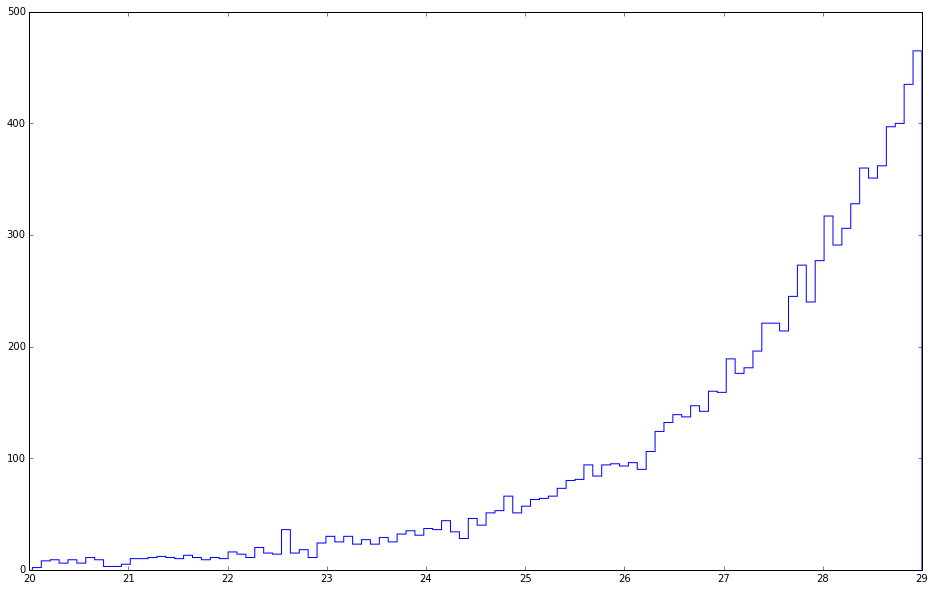

In [462]:
plt.hist(sample_lf(10000, .5, 20, 29), bins=100, histtype='step')
None

# Emceemr tests 

In [5]:
import emceemr
from emceemr import priors
import rgbmcmr

In [6]:
def make_fake_rgb(alpha, beta, mu, brightlimit, faintlimit, nmax, fracrgb):
    """
    
    returns mag0, isrgb
    """    
    #a = alpha + 1
    #b = beta + 1    
    #rgb = np.random.power(a, nmax)*(faintlimit-brightlimit) + brightlimit
    #foreground = np.random.power(b, nmax)*(faintlimit-brightlimit) + brightlimit
    
    rgb = sample_lf(nmax, alpha, brightlimit, faintlimit)
    foreground = sample_lf(nmax, beta, brightlimit, faintlimit)
    
    rgbmsk = rgb>mu
    fgmsk = foreground<mu
    rgb = rgb[rgbmsk]
    foreground = foreground[fgmsk]
    
    starting_fracrgb = len(rgb)/(len(foreground)+len(rgb))
    if starting_fracrgb>fracrgb:
        #too many RGBs
        nrgb = len(foreground)*fracrgb/(1-fracrgb)
        rgb = rgb[:nrgb]
    else:
        #too many fgs
        nfg = len(rgb)*(1-fracrgb)/fracrgb
        foreground = foreground[:nfg]
    
    mags = np.concatenate((rgb, foreground))
    isrgb = np.zeros(len(mags), dtype=bool)
    isrgb[:len(rgb)] = True
    
    unsorti = np.random.permutation(len(mags))
    mags = mags[unsorti]
    isrgb = isrgb[unsorti]
    
    return mags, isrgb

In [7]:
#median absolute deviation from ASTs
madmodel = models.Legendre1D(20, c0=-3954355396.3633738, c1=1353694208.4087687, c2=-124848799.79526304, c3=4897226.378521032, c4=-57041.00249220571, c5=-1549.1100474853888, c6=30.190195895799725, c7=1.1368681316643618, c8=-0.03563103282644921, c9=6.0712498989515646e-05, c10=4.892644246415783e-06, c11=8.248737934921185e-08, c12=-2.3350690477921424e-09, c13=-1.8352224226398223e-11, c14=5.350673251357965e-13, c15=2.4468515243894513e-15, c16=2.6121935517894807e-17, c17=-4.622081469223215e-18, c18=8.23871918441632e-20, c19=-6.005849952016176e-22, c20=1.6539943309668438e-24)

a= 0.690775527898


(397, 67, 0.8556034482758621)

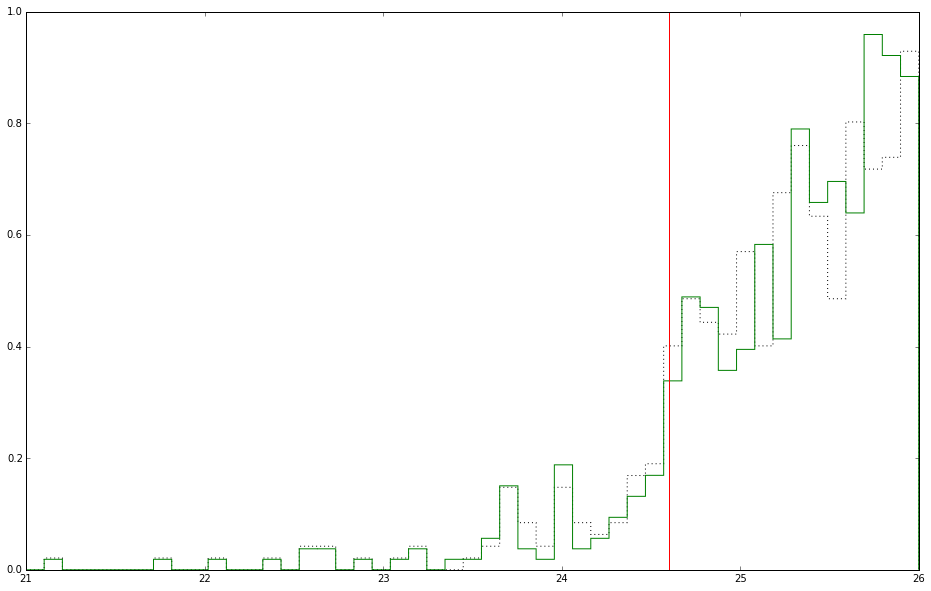

In [8]:
a = np.log(10)*.3
print('a=',a)
b = 1
mu = 24.6

realmags, isrgb = make_fake_rgb(a, b, mu, 21, 29, 5000, .986)

asterrs = madmodel(realmags)*1.483
asterrmags = realmags+np.random.randn(len(realmags))*asterrs


bins = np.linspace(21,26,50)
plt.hist(realmags, bins=bins,histtype='step',normed=True, ls='dotted', color='k')
plt.hist(asterrmags, bins=bins,histtype='step',normed=True, color='g')

inwindow = (bins[0]<realmags)&(realmags<bins[-1])
inrgbwindow = inwindow&(realmags>mu)
inotherwindow = inwindow&(realmags<mu)

plt.axvline(mu,color='r')
np.sum(inrgbwindow), np.sum(inotherwindow), np.sum(inrgbwindow)/np.sum(inwindow)

## Now do test runs of the MCMC

In [416]:
pris = dict(tipmag=priors.UniformPrior(23, 25.5),
            alphargb=priors.UniformPrior(0, 2), 
            alphaother=priors.UniformPrior(0, 2),
            fracother=priors.UniformPrior(0,0.5))

### "Intrinsic" mags 

In [417]:
astmod = rgbmcmr.RGBModel(realmags[inwindow], None, priors=pris)

In [418]:
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-12-07 13:41:12.380134
Took 0.0996810674667 min


Acors:
tipmag: 55.3196610758
alphargb: 51.752118818
alphaother: 56.5153069494
fracother: 58.0363964448
Acceptance Fractions:
[ 0.4288,  0.4052,  0.425 ,  0.419 ,  0.422 ,  0.417 ,  0.4242,  0.445 ,
  0.4294,  0.44  ,  0.4112,  0.4202,  0.448 ,  0.4254,  0.4268,  0.4324]


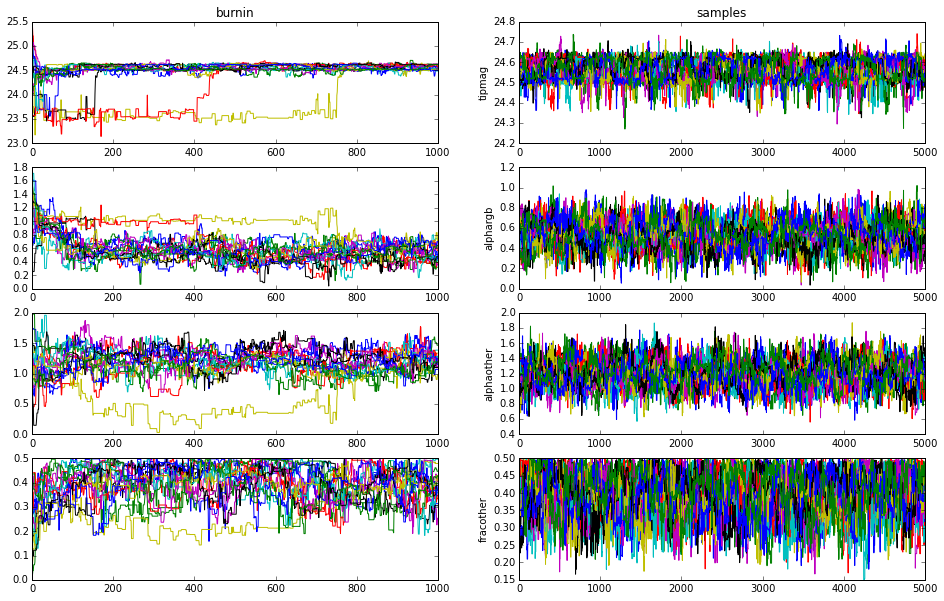

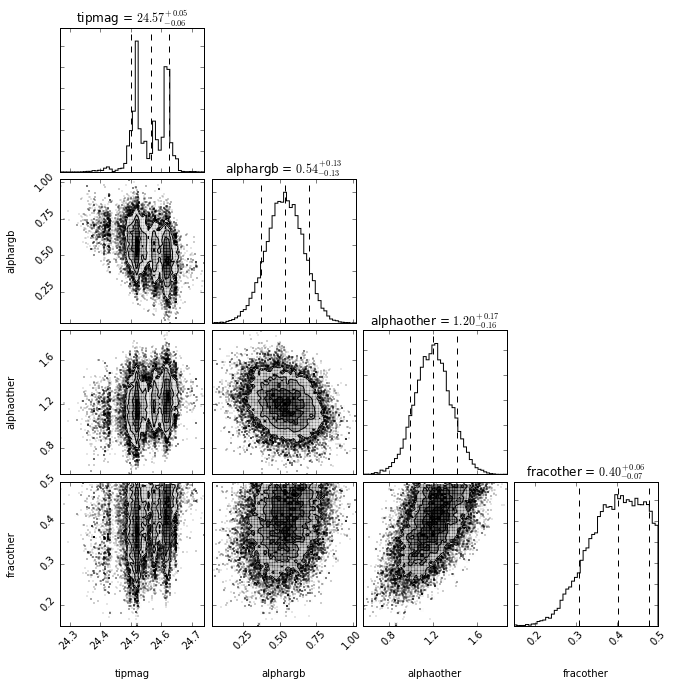

In [419]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

### With AST 

In [420]:
astmod = rgbmcmr.RGBModel(asterrmags[inwindow], madmodel(asterrmags[inwindow])*1.483, priors=pris)

In [421]:
#experimental timing run
st = time.time()
sampler = astmod.initialize_and_sample(15, burnin=5)
et = time.time()
dt = (et - st)*u.second
    
ntarg = 6000
print('20 samples took', dt, 'which scales up to',ntarg,'samples in',(dt*ntarg/20).to(u.minute))

20 samples took 0.121109962463 s which scales up to 6000 samples in 0.605549812317 min


In [422]:
#now the real deal
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-12-07 13:41:22.224300
Took 0.547262366613 min


Acors:
tipmag: 52.5663537246
alphargb: 47.0259375048
alphaother: 43.913599048
fracother: 44.5674419731
Acceptance Fractions:
[ 0.5532,  0.5646,  0.552 ,  0.5516,  0.5466,  0.5632,  0.5634,  0.5402,
  0.5556,  0.5446,  0.5212,  0.5654,  0.561 ,  0.5484,  0.5344,  0.5598]


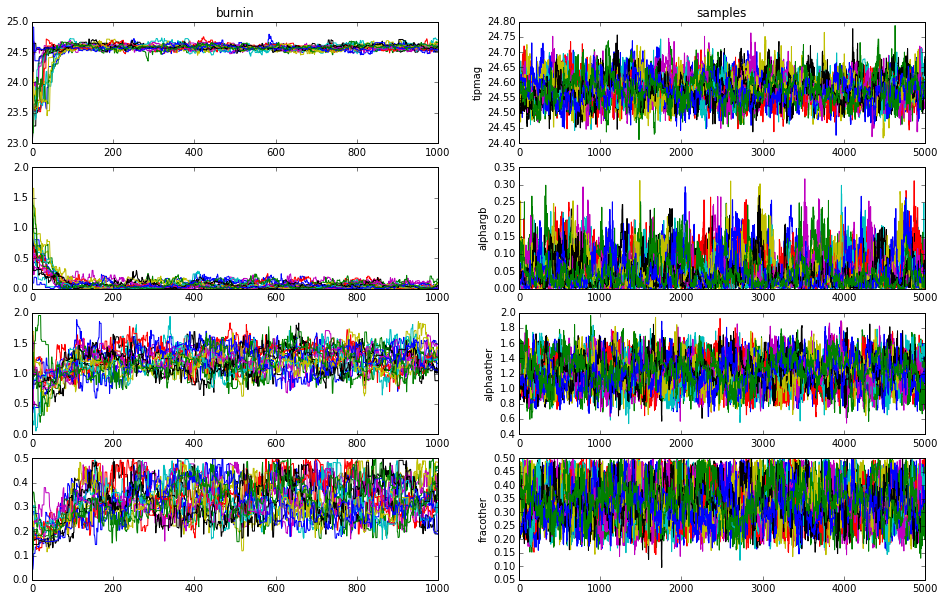

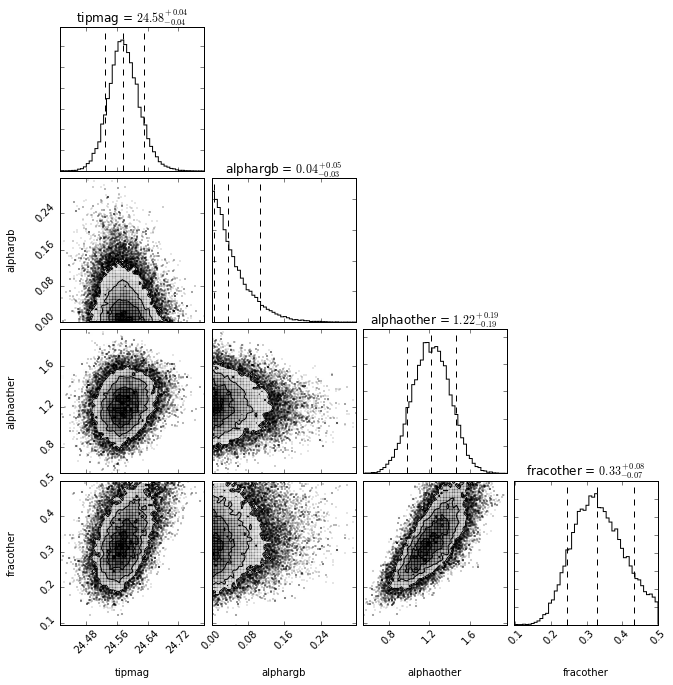

In [423]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

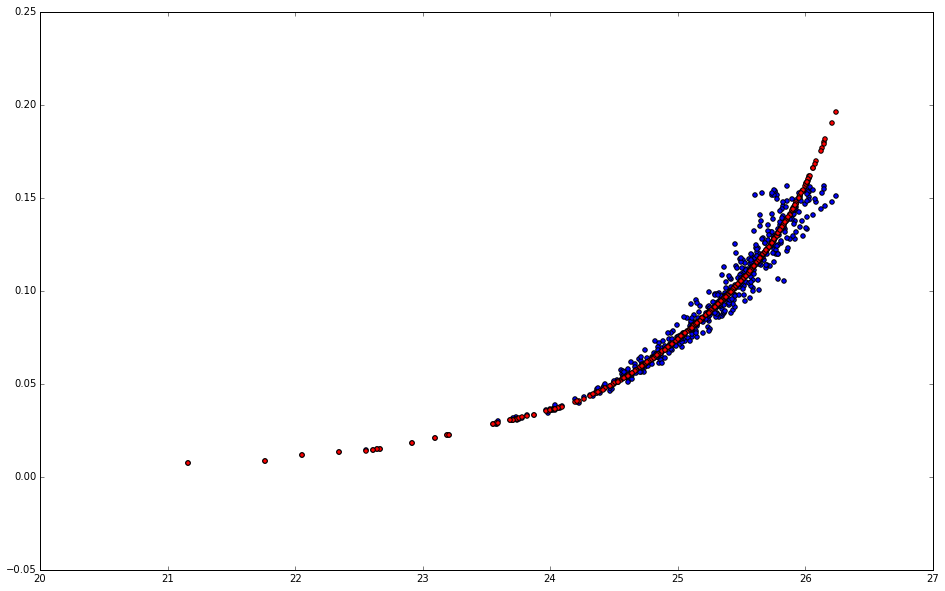

In [424]:
plt.scatter(asterrmags[inwindow], asterrs[inwindow])
plt.scatter(asterrmags[inwindow], madmodel(asterrmags[inwindow])*1.483,c='r')

## Test with the  function models

In [425]:
astmod = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=np.linspace(21, 29,100), 
                          uncfunc=lambda x:madmodel(x)*1.483,
                          priors=pris)
samples = 1500
burnin = 2

In [426]:
#experimental timing run
st = time.time()
sampler = astmod.initialize_and_sample(15, burnin=5)
et = time.time()
dt = (et - st)*u.second
    
nallsamps = burnin+samples
print('20 samples took', dt, 'which scales up to',nallsamps,'samples in',(dt*nallsamps/20).to(u.minute))

20 samples took 1.34762692451 s which scales up to 1502 samples in 1.68677970052 min


In [427]:
#now the real deal
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(samples, burnin=burnin)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-12-07 13:42:00.013404
Took 1.64586029847 min


Acors:
tipmag: 62.2440707956
alphargb: 34.5443503392
alphaother: 73.8804382659
fracother: 83.411566027
Acceptance Fractions:
[ 0.49      ,  0.48133333,  0.49      ,  0.50866667,  0.50533333,
  0.51266667,  0.50466667,  0.504     ,  0.532     ,  0.50666667,
  0.53733333,  0.48133333,  0.50133333,  0.48      ,  0.526     ,  0.482     ]


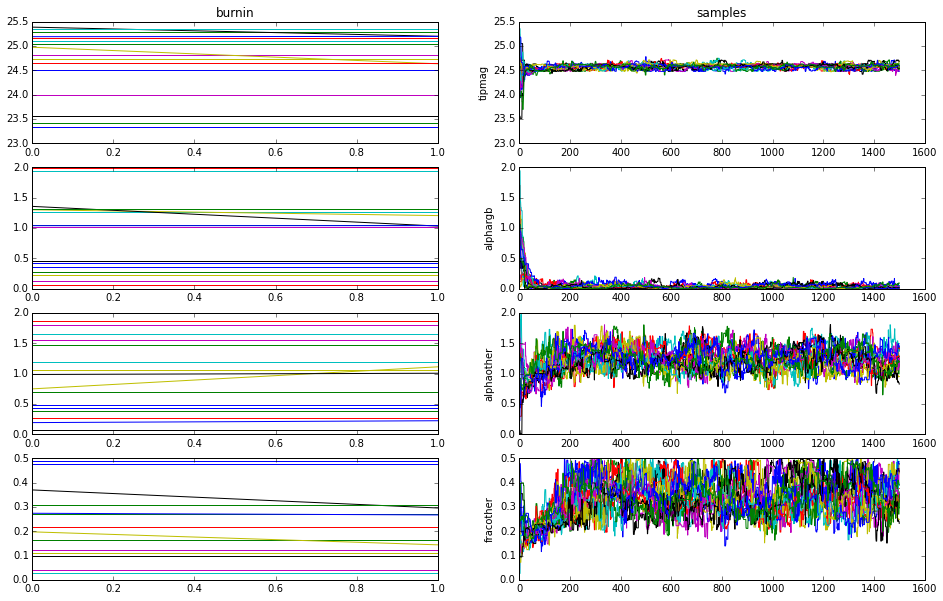

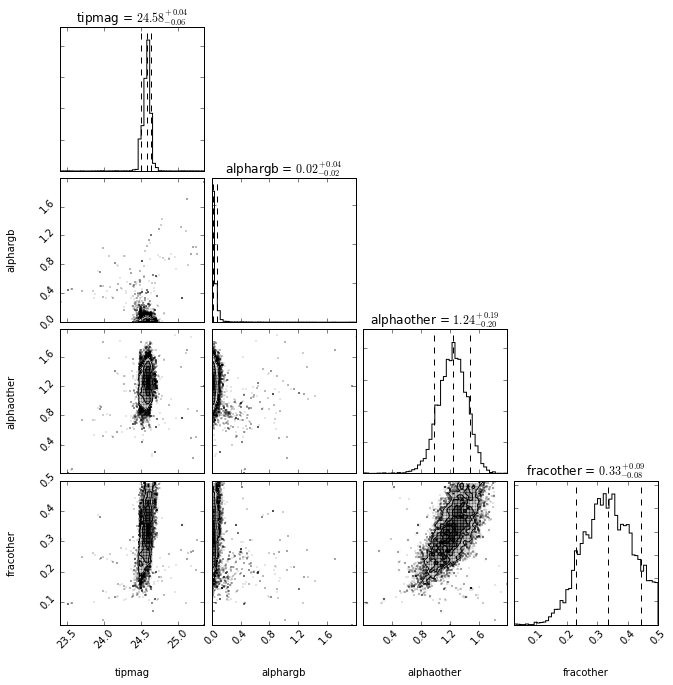

In [428]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

## Show LF models for fiducial case

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log


(0.99950631630723907, 0.9991059285821553, 1.0003434030189366)

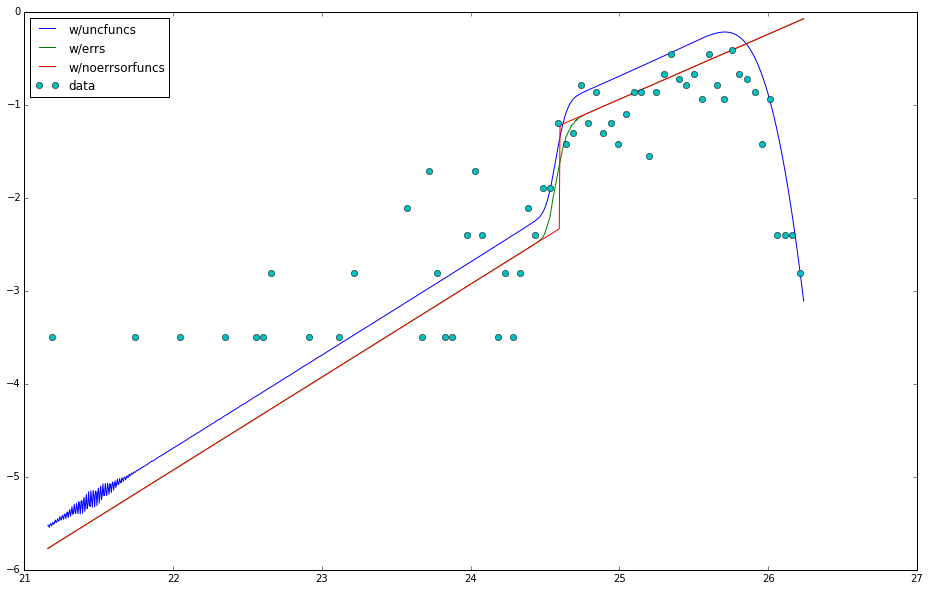

In [468]:
tipmag0 = 24.6
alpha0 = 0.7
beta0 = 1.
frac0 = .33

astmod1 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=np.linspace(21, 29,500), 
                          uncfunc=lambda x:madmodel(x)*1.483*1,
                          complfunc=lambda x:(x<26).astype(float),
                          priors=pris)
m1, lnp1 = astmod1.plot_lnprob(tipmag0, alpha0, beta0, frac0, 1000)

astmod2 = rgbmcmr.RGBModel(asterrmags[inwindow], asterrs[inwindow],
                          priors=pris)
m2, lnp2 = astmod2.plot_lnprob(tipmag0, alpha0, beta0, frac0, astmod2.magdata)

astmod3 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          priors=pris)
m3, lnp3 = astmod3.plot_lnprob(tipmag0, alpha0, beta0, frac0, 1000)

nh, bh = np.histogram(astmod1.magdata, bins=100)
plt.plot((bh[1:]+bh[:-1])/2, np.log(nh)-3.5,'o')

plt.legend(['w/uncfuncs', 'w/errs','w/noerrsorfuncs', 'data'],loc=0)
np.trapz(x=m1,y=np.exp(lnp1)), np.trapz(x=m2,y=np.exp(lnp2)), np.trapz(x=m3,y=np.exp(lnp3))

# Numerical derivative tests 

In [23]:
from scipy.stats import norm
from scipy.special import erf

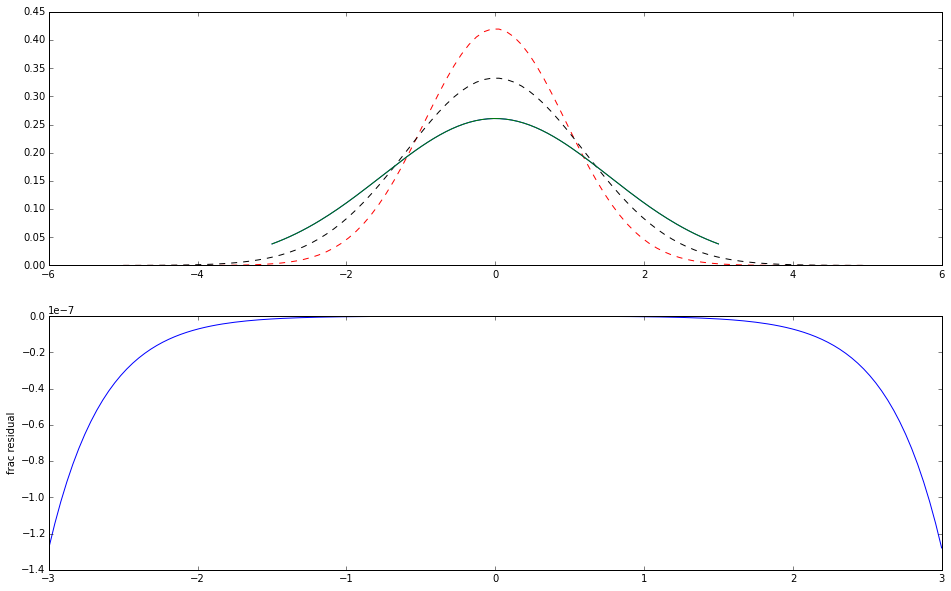

In [105]:
#two gaussians convolved
s1 = 0.95
s2 = 1.2
s12 = np.hypot(s1, s2)

norm1 = norm(scale=s1)
norm2 = norm(scale=s2)
norm12 = norm(scale=s12)

x = np.linspace(-5,5, 100) # integrate over this
y = np.linspace(-3,3, 150) # the independent variable
xr = x.reshape(x.size, 1)
yr = y.reshape(1, y.size)
integ = np.trapz(norm1.pdf(xr)*norm2.pdf(xr-yr), x, axis=0)

plt.subplot(2,1,1)
plt.plot(x, norm1.pdf(x), '--r')
plt.plot(x, norm2.pdf(x), '--k')
plt.plot(y, integ, c='b')
plt.plot(y, norm12.pdf(y), c='g')

plt.subplot(2,1,2)
true = norm12.pdf(y)
plt.plot(y, (integ-true)/true)
plt.ylabel('frac residual')
None

In [135]:
x=np.linspace(-6,6,100)
y = np.exp(-x**2/2)*(2*np.pi)**-0.5 *np.array([3,2,1]).reshape(3,1)
np.trapz(y,x.reshape(100),axis=1),x.shape,y.shape

(array([ 2.99999999,  2.        ,  1.        ]), (100,), (3, 100))

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


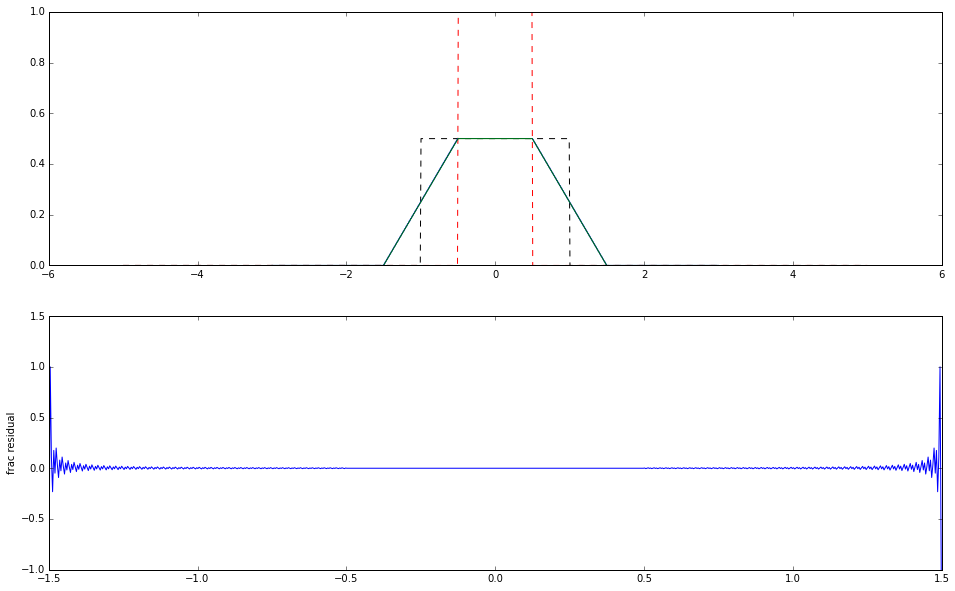

In [102]:
#square w/square
w1 = 1.
w2 = 2.0

def make_theta(x, w, cen=0):
    theta = np.ones_like(x)/w
    theta[x>(cen+w/2.)] = 0
    theta[x<(cen-w/2.)] = 0
    return theta

x = np.linspace(-5,5, 1000) # integrate over this
y = np.linspace(-3,3, 1500) # the independent variable
xr = x.reshape(x.size, 1)
yr = y.reshape(1, y.size)

theta = make_theta(xr, w1)
theta2 = make_theta(xr, w2)
theta2_integ = make_theta(xr-yr, w2)

integ = np.trapz(theta*theta2_integ, xr, axis=0)

#theta with triangles
outer_edge = (w1+w2)/2
inner_edge = np.ptp([w1,w2])/2
true = make_theta(y, inner_edge*2)*inner_edge
slope = 0.5/(inner_edge-outer_edge)
true[y>inner_edge] = (y[y>inner_edge]-outer_edge)*slope
true[y>outer_edge] = 0

true[y<-inner_edge] = (y[y<-inner_edge]+outer_edge)*-slope
true[y<-outer_edge] = 0

plt.subplot(2,1,1)
plt.plot(x, theta.ravel(), '--r')
plt.plot(x, theta2.ravel(), '--k')
plt.plot(y, integ, c='b')
plt.plot(y, true, c='g')

plt.subplot(2,1,2)
plt.plot(y, (integ-true)/true)
plt.ylabel('frac residual')